In [119]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [120]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [121]:
!ls

Bike.ipynb
Lab03_Linear.ipynb
sampleSubmission.csv
test.csv
train.csv


In [122]:
raw_data = pd.read_csv('train.csv', header=0, sep=',')

In [123]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


### Data Fields

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

### Посмотрим на размерность данных

In [124]:
print raw_data.shape

(10886, 12)


### Посмотрим на пропущенные значения

In [125]:
raw_data.isnull().values.any()

False

### Предобработка данных

In [126]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.1+ MB


### Почти все данные являются числовыми, кроме поля datetime - но мы знаем, что это дата (необходимо преобразование)

In [127]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

#### Построим два новых признака month/hour

In [128]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [129]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,1,4


#### Обучение и отложенный тест 

#### Данные отсортированы по дате, обучимся на более поздних датах, и предскажем на более новых

In [130]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

#### Оценим размеры полученных наборов данных

In [131]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


#### Убедимся, что вся обучающая выборка в более раннем периоде времени

In [132]:
print 'train period from {} to {}'.format(train_data.datetime.min(),
                                            train_data.datetime.max())
print 'test period from {} to {}'.format(hold_out_test_data.datetime.min(),
                                            hold_out_test_data.datetime.max())

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
test period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

In [133]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime','count'], axis=1)

In [134]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime','count'], axis=1)

### Целевая функция на обучающей выборке и на отложенном тесте

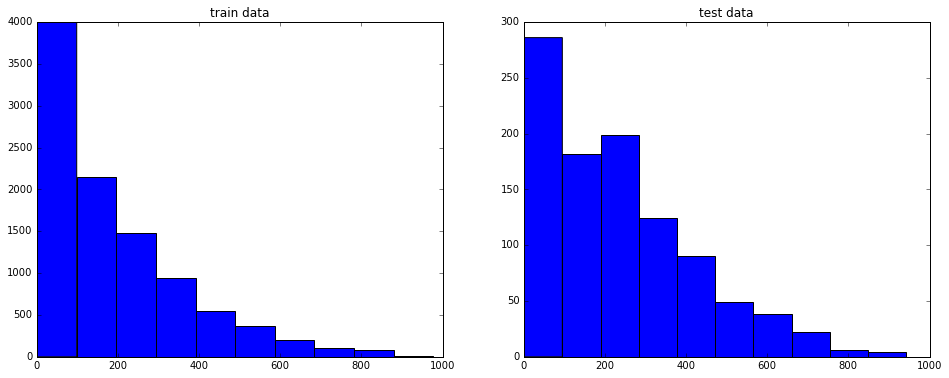

In [135]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### 

#### Так как мы решаем задачу регрессии, то  возьмем пока только числовые признаки

In [136]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [137]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [138]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


In [139]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


#### Модель

### Обучим SGDRegressor - регрессия на основе стохастического градиентного спуска

In [140]:
regressor = linear_model.SGDRegressor(random_state=241)

### Используем параметры по умолчанию

In [141]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

63128721585311.82

In [142]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [143]:
print regressor.predict(test_data)[:10]

[ -1.62470948e+14  -2.53655837e+14  -1.00438322e+14  -3.81177277e+13
  -4.57031463e+13  -6.92261315e+13  -7.05329597e+13  -4.86254147e+13
  -7.17239503e+13  -1.02094082e+14]


### Мы выводим слишком большие значения

In [144]:
regressor.coef_

array([  3.77897351e+10,   2.05412947e+10,  -5.77285640e+10,
        -7.54224054e+10,   2.47309032e+11,  -3.24387062e+11,
        -4.11646433e+10,   1.16412100e+10])

### Линейные модели сильно зависят от масштаба признаков

### Scaling

In [145]:
from sklearn.preprocessing import StandardScaler

In [146]:
## создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [147]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.02731674237117207

In [148]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [149]:
print regressor.predict(scaled_test_data)[:10]

[ 524.96954155  834.91858293  355.00495563  222.02891547  228.04338526
  325.01885579  328.01454543  308.01601945  346.01683336  446.00068097]


#### Отличаются примерно на 1. Скорее всего переобучились

In [150]:
print regressor.coef_

[ -3.14933415e-01   3.21581332e-01  -8.55908405e-03   1.28249391e-02
   5.08568013e+01   1.48008410e+02   4.12825490e-03   5.99074081e-03]


In [151]:
print map(lambda x : round(x, 2), regressor.coef_)

[-0.31, 0.32, -0.01, 0.01, 50.86, 148.01, 0.0, 0.01]


In [152]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0,3,13,1,0
1,9.02,13.635,80,0,8,32,1,1
2,9.02,13.635,80,0,5,27,1,2
3,9.84,14.395,75,0,3,10,1,3
4,9.84,14.395,75,0,0,1,1,4


### Похоже casual + registered = count

In [153]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [154]:
np.all(train_data.registered + train_data.casual == train_labels)

True

###  У нас линейная зависимость, которая полностью восстанавливает закономерность

In [155]:
train_data.drop(['registered', 'casual'], axis=1, inplace=True)
test_data.drop(['registered', 'casual'], axis=1, inplace=True)

In [156]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [157]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.00098148118769

#### Мы ошибаемся примерно 122 велосипеда  - реалистичная оценка

In [158]:
print map(lambda x : round(x, 2), regressor.coef_)

[32.37, 34.09, -45.59, 8.48, 14.74, 53.98]


### Теперь все признаки имеет хорошие коэффициенты

#### Теперь мы имеем некоторую базовую модель, которую считаем правильной. Проведем ее улучшения

#### Подберем оптимальные параметры для нашей модели

#### Pipeline

In [159]:
# создаем pipeline из 2х шагов: scaling и классификация
pipe_line = pipeline.Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [160]:
pipe_line.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipe_line.predict(test_data))

121.00098148118769

### Перебор параметров

In [161]:
pipe_line.get_params().keys()

['regression__random_state',
 'regression__n_iter',
 'regression__epsilon',
 'regression__power_t',
 'regression__alpha',
 'regression__eta0',
 'regression__loss',
 'scaling',
 'steps',
 'scaling__copy',
 'regression__fit_intercept',
 'regression__warm_start',
 'regression__penalty',
 'regression__learning_rate',
 'regression__average',
 'regression__verbose',
 'regression__shuffle',
 'regression__l1_ratio',
 'regression',
 'scaling__with_std',
 'scaling__with_mean']

In [162]:
parameters_grid = {
    'regression__loss' : ['huber','epsilon_insensitive', 'squared_loss'],
    'regression__n_iter' : [3, 5, 10, 50],
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0, 1]
}

In [163]:
grid_cv = grid_search.GridSearchCV(pipe_line, parameters_grid, scoring='mean_absolute_error', cv=4)

In [164]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 19.7 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=241, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'regression__n_iter': [3, 5, 10, 50], 'regression__loss': ['huber', 'epsilon_insensitive', 'squared_loss'], 'scaling__with_mean': [0, 1], 'regression__alpha': [0.0001, 0.01], 'regression__penalty': ['l1', 'l2', 'none']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [165]:
print grid_cv.best_score_
print grid_cv.best_params_

-109.098701722
{'regression__n_iter': 50, 'regression__loss': 'epsilon_insensitive', 'scaling__with_mean': 0, 'regression__alpha': 0.0001, 'regression__penalty': 'none'}


#### Оценка лучшей модели на отложенном тесте

In [166]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

135.29387985997519

In [167]:
np.mean(test_labels)

232.15899999999999

In [168]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [169]:
print test_labels[:10]

[525 835 355 222 228 325 328 308 346 446]


In [170]:
print test_predictions[:10]

[  95.12962029  110.11404882  152.28964715  177.03585028  195.88837869
  202.8019018   206.99628453  226.86676162  234.37761287  241.80254924]


#### Предсказанные и реальные метки сильно отличаются

#### Изобразим графически отображение в пространстве правильных целевых меток и наших предсказаний
#### (ожидаем диагональ в облаке точек)

(-100, 1100)

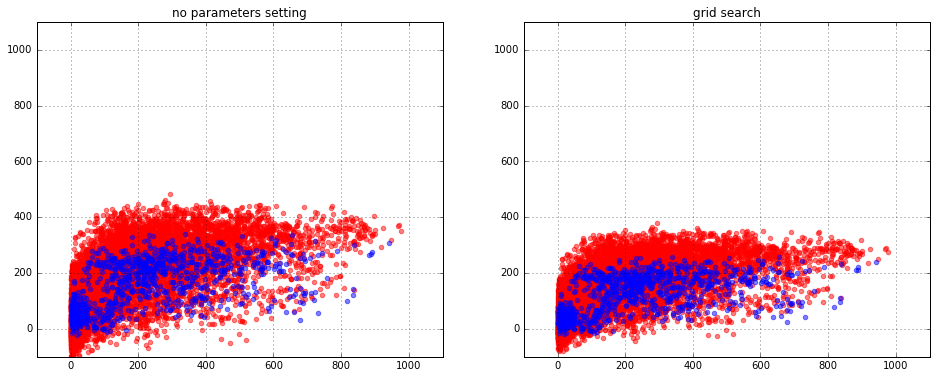

In [171]:
pylab.figure(figsize=(16,6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipe_line.predict(train_data), alpha = 0.5, color = 'red')
pylab.scatter(test_labels, pipe_line.predict(test_data), alpha = 0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)


pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha = 0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha = 0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)




### Фактически - наша модель слабая и оптимизация по параметрам ничего не дала!

In [172]:
raw_data = pd.read_csv('train.csv', header=0, sep=',')
# convert
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
# new features
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)
# split dataset
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]
# оценим выборку
print raw_data.shape, train_data.shape, hold_out_test_data.shape

(10886, 14) (9886, 14) (1000, 14)


In [173]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime','count'], axis=1)

#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime','count'], axis=1)

#### Необходимо получить логический индекс

In [174]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [175]:
print binary_data_columns
print binary_data_indices

['holiday', 'workingday']
[False  True  True False False False False False False False False False]


In [176]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [177]:
print categorical_data_columns
print categorical_data_indices

['season', 'weather', 'month']
[ True False False  True False False False False False False  True False]


In [178]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [179]:
print numeric_data_columns
print numeric_data_indices

['temp', 'atemp', 'humidity', 'windspeed']
[False False False False  True  True  True  True False False False False]


#### Pipeline

In [180]:
grid_cv.best_params_

{'regression__alpha': 0.0001,
 'regression__loss': 'epsilon_insensitive',
 'regression__n_iter': 50,
 'regression__penalty': 'none',
 'scaling__with_mean': 0}

In [181]:
regressor = linear_model.SGDRegressor(random_state=241, n_iter = 50, loss = 'epsilon_insensitive',
                                     penalty = 'none', alpha = 0.0001)

In [182]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [183]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000AD7D7B8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(... penalty='none', power_t=0.25,
       random_state=241, shuffle=True, verbose=0, warm_start=False))])

In [184]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

156.66350714086622

### Мы получили достаточно большую ошибку - примерно то же самое, что и было раньше т.е. мы не получили улучшение путем преобразование данных

#### Посмотрим, возможно, подбор параметр сможет на это повлиять

In [185]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__transformer_weights',
 'feature_processing__transformer_list',
 'model_fitting__fit_intercept',
 'feature_processing',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',
 'model_fitting__l1_ratio',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'feature_processing__categorical_variables_processing__hot_encoding_

In [186]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0.1],
    'model_fitting__eta0' : [0.001, 0.05]
}

In [187]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid,
                                   scoring='mean_absolute_error', 
                                  cv=4)

In [188]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 2.14 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000000AD7D7B8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(... penalty='none', power_t=0.25,
       random_state=241, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.001, 0.05], 'model_fitting__alpha': [0.0001, 0.001, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [189]:
print grid_cv.best_score_
print grid_cv.best_params_

-116.476242983
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 0.0001}


### Оценка по отложенному тесту

In [190]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [191]:
metrics.mean_absolute_error(test_labels, test_predictions)

146.12020914199547

##### Мы ошибаемся в среднем на 146 велосипедов, чуть лучше, чем было, но попрежнему очень и очень плохо, т.е. оптимизация параметров не принесла результатов

In [192]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [193]:
print test_predictions[:20]

[ 131.54377029  142.37700198  196.20682762  221.5961532   239.5019078
  243.42614273  236.3138529   254.43462996  257.00308158  257.07549506
  240.48797483  223.13824235  187.9017521   165.12546246  149.00828258
  114.83925226  106.92548927   88.1784946    88.1784946    88.1784946 ]


#### Отобразим наши объекты в координатах исходных значений целевой метки и наших прогнозов

(-100, 1100)

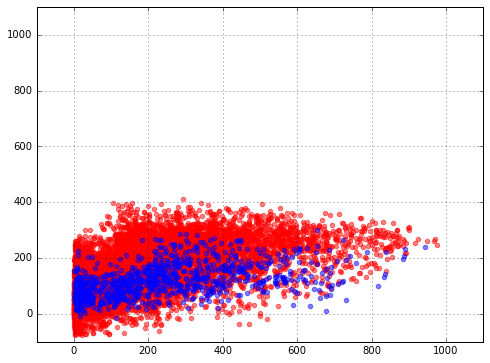

In [194]:
pylab.figure(figsize=(8, 6))

pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha = 0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha = 0.5, color = 'blue')
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)

### Область точек достаточно долека от диагональной области точек, которая будет в случае хорошей модели; Наш график сильно похож на графики выше, следовательно, все наши преобразования - генерация новых признаков подбор параметров не привели к улучшению модели - мы не смогли ее улучшить

###  Мы строим линейную модель, это предполагает линейную зависимость между признаками и целевой переменной. Но это не всегда так - например, количество занятых велосипедов линейно зависят от времени - на каком-то отрезке это будет линейной зависимостью - количество занятых от времени, но на других отрезках наоборот. Эти же рассуждения можно применить к другим признакам - например, температуре, месяцу, давлению.

* Можно сгенерировать новые признаки
* Использовать другую модель (которые умеют учитывать не линейную зависимость между признаками и целевой функцией)

#### Обучим не линейную модель

In [195]:
from sklearn.ensemble import RandomForestRegressor

In [196]:
regressor = RandomForestRegressor(random_state = 0, max_depth=20, n_estimators=50)

In [197]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [198]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000115B6F28>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [199]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

137.58990315712026

In [200]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [201]:
estimator.predict(test_data)[:20]

array([ 144.68437726,  273.19408333,  193.29233333,  252.12344444,
        344.22      ,  263.89666667,  287.62822222,  393.06      ,
        299.84      ,  434.8       ,  433.56      ,  224.31333333,
        190.515     ,  202.38833333,  188.68541667,  146.80173389,
        196.96635294,  156.97101961,  156.97101961,  156.97101961])

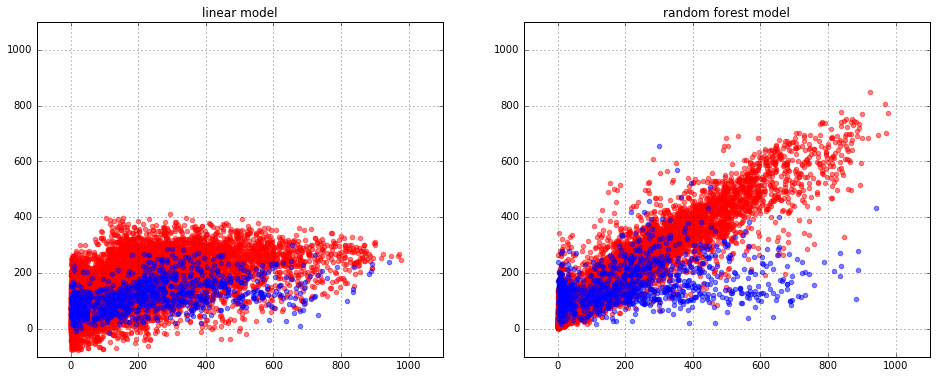

In [202]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

#### Попробуем улучшить модель, подобрав параметры

In [203]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'model_fitting__oob_score',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__transformer_weights',
 'model_fitting__min_samples_leaf',
 'feature_processing__transformer_list',
 'model_fitting__n_estimators',
 'model_fitting__criterion',
 'model_fitting__max_leaf_nodes',
 'feature_processing',
 'feature_processing__categorical_variables_processing__hot_encoding__handle_unknown',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__categorical_variables_processing__hot_encoding__n_values',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'f

In [204]:
parameters_grid = {
    'model_fitting__n_estimators': [10,20,30, 50],
    'model_fitting__max_depth':[3,15,25,40]
}

In [205]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid,
                                   scoring='mean_absolute_error', 
                                  cv=4)

In [206]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 5min 16s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000115B6F28>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__max_depth': [3, 15, 25, 40], 'model_fitting__n_estimators': [10, 20, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [207]:
print grid_cv.best_score_
print grid_cv.best_params_

-122.11601435
{'model_fitting__max_depth': 3, 'model_fitting__n_estimators': 30}


In [208]:
test_predictions = grid_cv.best_estimator_.predict(test_data)
metrics.mean_absolute_error(test_labels, test_predictions)

144.477096061878

In [209]:
print test_labels[:20]

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [210]:
estimator.predict(test_data)[:20]

array([ 144.68437726,  273.19408333,  193.29233333,  252.12344444,
        344.22      ,  263.89666667,  287.62822222,  393.06      ,
        299.84      ,  434.8       ,  433.56      ,  224.31333333,
        190.515     ,  202.38833333,  188.68541667,  146.80173389,
        196.96635294,  156.97101961,  156.97101961,  156.97101961])

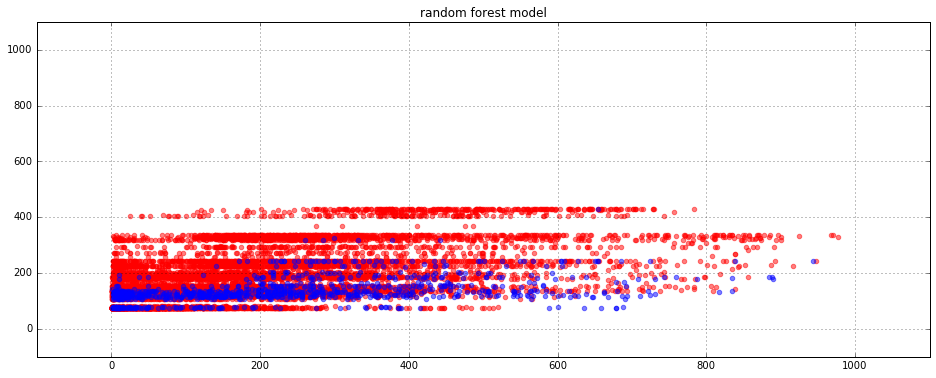

In [211]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')